# Reinforcement Learning for Trading

Author: Elkin Narváez Paz

* Email: elkinnarvaez2406@gmail.com
* LinkedIn: https://www.linkedin.com/in/elkinnarvaez/
* GitHub: https://github.com/elkinnarvaez

© All rights reserved.

## Libraries

In [194]:
import http.client
import requests
import json
import datetime
import statistics as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

## Constituents selection

In [195]:
constituents = pd.read_csv('data/constituents.csv')
constituents = constituents.drop(['SEC filings'], axis=1) #.rename(columns = {'Security': 'Constituent'})
constituents_by_sector = {}
for index, row in constituents.iterrows():
    if(row['GICS Sector'] in constituents_by_sector):
        constituents_by_sector[row['GICS Sector']].append(row)
    else:
        constituents_by_sector[row['GICS Sector']] = list(); constituents_by_sector[row['GICS Sector']].append(row)
for sector in constituents_by_sector:
    constituents_by_sector[sector] = pd.DataFrame(constituents_by_sector[sector])

### Sector Breakdown

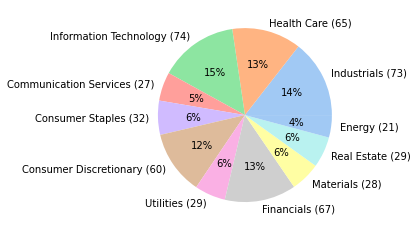

In [196]:
number_of_constituents_by_sector = list()
sectors = list()
for sector in constituents_by_sector:
    sectors.append(sector + ' (' + str(constituents_by_sector[sector].shape[0]) + ')')
    number_of_constituents_by_sector.append(constituents_by_sector[sector].shape[0])

colors = sns.color_palette('pastel')[0:len(sectors)]

plt.pie(number_of_constituents_by_sector, labels = sectors, colors = colors, autopct='%.0f%%')
plt.show()

### Selection

In [197]:
def change_to_hypen(symbol):
    """
        Description: Change the constituent symbol representation to hypen if a dot is found. For instance, the symbol BF.B will be changed to BF-B.
    """
    new_symbol = ''
    for i in range(len(symbol)):
        if(symbol[i] == '.'):
            new_symbol += '-'
        else:
            new_symbol += symbol[i]
    return new_symbol

In [198]:
p = 0.1 # percentage of stocks that will be selected from each sector
constituent_symbols = list()
for sector in constituents_by_sector:
    sector_constituents = constituents_by_sector[sector]
    n = math.ceil(sector_constituents.shape[0]*p) # Number of stocks that will be selected from this sector
    constituents_already_selected = set()
    number_selections = 0
    random.seed(0)
    while(number_selections < n):
        index = random.randint(0, sector_constituents.shape[0] - 1)
        if(index not in constituents_already_selected):
            constituent_symbols.append(change_to_hypen(sector_constituents.iloc[index]['Symbol']))
            constituents_already_selected.add(index)
            number_selections += 1
print(str(len(constituent_symbols)) + " constituents have been selected")

55 constituents have been selected


## Data gathering using YH Finance API

In [199]:
indicators = {}

conn = http.client.HTTPSConnection("yh-finance.p.rapidapi.com")

headers = {
    'x-rapidapi-host': "yh-finance.p.rapidapi.com",
    'x-rapidapi-key': "fc1708951fmshca8b1e8a9e96604p126192jsnf88ca47a0efd"
    }

In [200]:
for symbol in constituent_symbols:
    print(symbol)
    conn.request("GET", f"/stock/v3/get-chart?interval=60m&symbol={symbol}&range=2y&region=US&includePrePost=false&useYfid=true&includeAdjustedClose=true&events=capitalGain%2Cdiv%2Csplit", headers=headers)

    res = conn.getresponse()
    data = res.read()

    result = json.loads(data.decode("utf-8"))["chart"]["result"][0]

    indicators[symbol] = {
        "timestamp": list(map(lambda x: datetime.datetime.fromtimestamp(x), result["timestamp"])),
        "high": result["indicators"]["quote"][0]["high"],
        "volume": result["indicators"]["quote"][0]["volume"],
        "open": result["indicators"]["quote"][0]["open"],
        "low": result["indicators"]["quote"][0]["low"],
        "close": result["indicators"]["quote"][0]["close"]
    }

PH
RSG
AME
ITW
UNP
TXT
PWR
LHX
PFE
STE
ABC
IDXX
WST
REGN
JNJ
NLOK
PAYX
APH
INTC
TEL
SWKS
NXPI
JNPR
FOX
TTWO
IPG
PEP
PG
BF-B
KMB
UAA
HAS
TPR
VFC
HD
APTV
WEC
DUK
PEG
PNC
RJF
AON
ICE
WTW
TFC
PGR
WRK
FMC
SEE
WELL
FRT
UDR
MRO
MPC
BKR


## Creation of trading signals

In [23]:
tradingSignals = {}
for symbol in stockSymbols:
    tradingSignals[symbol] = {}

### Simple Moving Average (SMA)

In [32]:
def SMA(symbol, numPeriods):
    """
        Input:
            - symbol: the symbol of the stock for which the SMA will be calculated to -> str
            - numPeriods: number of time periods over which to average -> int
        Output:
            SMA values
    """
    smaValues = []
    
    history = [] # history of prices
    for closePrice in indicators[symbol]['close']:
        history.append(closePrice)
        if(len(history) > numPeriods): # remove the oldest price because we only average over the last 'numPeriods' prices
            del history[0]
        smaValues.append(stats.mean(history))
        
    return smaValues

### Exponential Moving Average (EMA)

In [33]:
def EMA(symbol, numPeriods):
    """
        Input:
            - symbol: the symbol of the stock for which the EMA will be calculated to -> str
            - numPeriods: number of time periods over which to average -> int
        Output:
            EMA values
    """
    emaValues = []
    
    K = 2 / (numPeriods + 1) # smoothing constant
    ema = 0
    
    for closePrice in indicators[symbol]['close']:
        if(ema == 0):
            ema = closePrice
        else:
            ema = (closePrice - ema) * K + ema
        emaValues.append(ema)
    
    return emaValues

### Absolute Price Oscillator (APO)

In [30]:
def APO(symbol, numPeriodsFast, numPeriodsSlow):
    """
        Input:
            - symbol: the symbol of the stock for which the APO will be calculated to -> str
            - numPeriodsFast: number of time periods for the fast EMA -> int
            - numPeriodsSlow: number of time periods for the slow EMA -> int
        Output:
            APO values
    """
    apoValues = []

    emaFast = 0
    Kfast = 2 / (numPeriodsFast + 1) # fast EMA smoothing factor
    emaSlow = 0
    Kslow = 2 / (numPeriodsSlow + 1) # slow EMA smoothing factor
    
    for closePrice in indicators[symbol]['close']:
        if(emaFast == 0): # First observation
            emaFast = closePrice
            emaSlow = closePrice
        else:
            emaFast = (closePrice - emaFast) * Kfast + emaFast
            emaSlow = (closePrice - emaSlow) * Kslow + emaSlow
        apoValues.append(emaFast - emaSlow)
        
    return apoValues

### Moving Average Convergence Divergence (MACD)

In [31]:
def MACD(symbol, numPeriodsFast, numPeriodsSlow, numPeriodsMacd):
    """
        Input:
            - symbol: the symbol of the stock for which the APO will be calculated to -> str
            - numPeriodsFast: number of time periods for the fast EMA -> int
            - numPeriodsSlow: number of time periods for the slow EMA -> int
            - numPeriodsMacd: number of time periods for the MACD EMA -> int
        Output:
            MACD values
    """
    macdSignalValues = []
    macdHistogramValues = []

    emaFast = 0
    Kfast = 2 / (numPeriodsFast + 1) # fast EMA smoothing factor
    emaSlow = 0
    Kslow = 2 / (numPeriodsSlow + 1) # slow EMA smoothing factor
    emaMacd = 0
    Kmacd = 2 / (numPeriodsMacd + 1) # MACD EMA smoothing factor
    
    for closePrice in indicators[symbol]['close']:
        if(emaFast == 0): # First observation
            emaFast = closePrice
            emaSlow = closePrice
        else:
            emaFast = (closePrice - emaFast) * Kfast + emaFast
            emaSlow = (closePrice - emaSlow) * Kslow + emaSlow
        
        macd = emFast - emaSlow
        if(emaMacd == 0):
            emaMacd = macd
        else:
            emaMacd = (macd - emaMacd) * Kmacd + emaMacd
        
        macdSignalValues.append(emaMacd)
        macdHistogramValues.append(macd - emaMacd)
        
    return macdSignalValues, macdHistogramValues